In [37]:
import pandas as pd
import numpy as np
from numpy.linalg import eigh
import warnings
import matplotlib.pyplot as plt
from matplotlib import cm
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from collections import Counter
from itertools import combinations
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.neighbors import KNeighborsClassifier
warnings.filterwarnings('ignore')

In [3]:
dataset = pd.read_csv('../data/heart_disease_dataset_UCI.csv')
dataset.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [4]:
standardScalar = StandardScaler()
target_columns = ['age','trestbps','chol','thalach','oldpeak']
dataset[target_columns] = standardScalar.fit_transform(dataset[target_columns])
featurenames = dataset.columns.values
dataset.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,0.952197,1,3,0.763956,-0.256334,1,0,0.015443,0,1.087338,0,0,1,1
1,-1.915313,1,2,-0.092738,0.072199,0,1,1.633471,0,2.122573,0,0,2,1
2,-1.474158,0,1,-0.092738,-0.816773,0,0,0.977514,0,0.310912,2,0,2,1
3,0.180175,1,1,-0.663867,-0.198357,0,1,1.239897,0,-0.206705,2,0,2,1
4,0.290464,0,0,-0.663867,2.082050,0,1,0.583939,1,-0.379244,2,0,2,1


In [5]:
#Dividing into input and output
X= dataset.drop(['target'], axis=1)
Y= dataset['target']
X_train, X_test, Y_train, Y_test= train_test_split(X, Y, test_size=0.25, random_state=40)

In [6]:
def dist(x, y, p):
    dim = len(x)
    dist = 0
    for i in range(dim):
        dist += abs(x[i] - y[i])**p
    return dist**(1/p)

In [7]:
def knn_sfs(distfunc, X_train, Y_train, k):
    accuracy = 0
    for p in X_train.index:
        Xtraindataselect = X_train.drop(index=p)
        leaveone = X_train.loc[p].to_numpy()
        Xtraindataselect = Xtraindataselect.to_numpy()
        Ytraindataselect = Y_train.drop(index=p)
        leaveonetrain = Y_train.loc[p]
        
        Y_prediction = []
        distances = []
                
        for j in Xtraindataselect:
            distances.append(dist(leaveone,j,distfunc))
        df_dist = pd.DataFrame(index=Ytraindataselect.index, columns=['dist'], data=distances)
        df_neighbors = df_dist.sort_values(by=['dist'], axis=0)[:k]
        neighbortally = Counter(Ytraindataselect[df_neighbors.index])
        Y_prediction.append(neighbortally.most_common(1)[0][0])
        if(leaveonetrain == Y_prediction):
                accuracy += 1
        Xtraindataselect = []
        Ytraindataselect = []
        leaveonetrain = []
    accuracy = accuracy/len(X_train.index)
    return accuracy

In [8]:
# Calculate the minkowski distance between every new data point in X_test and all points in X_train, show accuracy
def knn (distfunction, X_train_arr, X_test_arr, Y_train, Y_test, k):
    Y_prediction = []
    for i in X_test_arr:
        distances = []
        for j in X_train_arr:
            distances.append(dist(i,j,distfunction))
        df_dist = pd.DataFrame(index=Y_train.index, columns=['dist'], data=distances)
        df_neighbors = df_dist.sort_values(by=['dist'], axis=0)[:k]
        neighbortally = Counter(Y_train[df_neighbors.index])
        Y_prediction.append(neighbortally.most_common(1)[0][0])

    cmknn = confusion_matrix(Y_test, Y_prediction)
    #print("Minkowski distance p = ", distfunction, "| K Neighbors =", k,'\n', cmknn)
    #print(Y_prediction)
    #print("\nAccuracy=", accuracy_score(Y_test, Y_prediction),"\n")
    return Y_prediction

In [9]:
def sfs(distfunc, k):
    #SFS

    sfsmax = 5
    selectfeat = []
    tempselect = []
    features = []
    traindataselect = []
    bestaccuracy = 0
    accuracy = 0
    bestfeat = ''
    features = list(X_train.columns)
    #print(features)

    while(len(selectfeat) < sfsmax):
        for j in range(len(selectfeat)):
                tempselect.append(selectfeat[j])
        for i in range(len(features)):
            tempselect.append(features[i])
            #print('Featureset: {}'.format(tempselect))
            accuracy = knn_sfs(distfunc,X_train[tempselect],Y_train,k)
            #print('Accuracy: {}'.format(accuracy))
            if (bestaccuracy < accuracy):
                bestaccuracy = accuracy
                bestfeat = features[i]
            tempselect.pop(-1)

        selectfeat.append(bestfeat)
        features.remove(bestfeat)
        #print("============================================")
        #print("\nBest feature to add: {}".format(bestfeat))
        #print("Accuracy with feature addition: {}".format(bestaccuracy))
        #print("Total features added: {}\n".format(len(selectfeat)))
        #print("============================================")
        bestaccuracy = 0
        del tempselect[:]
        
    featurenumbers = []
    for i in selectfeat:
        for j in range(len(featurenames)):
            if (i == featurenames[j]):
                featurenumbers.append(j + 1)
    featurenumbers.sort()
    print("Final featureset: {}".format(featurenumbers))
    return selectfeat


In [9]:
def pca_scratch(selectfeat, X):
    X_mean = np.mean(X[selectfeat].to_numpy(),axis=0)
    X_centered = X[selectfeat].to_numpy() - X_mean
    val, vect = eigh(np.cov(X_centered, rowvar = False))
    X_reduced = np.dot(vect.T,X_centered.T)
    return X_reduced

In [10]:
X_train_arr = X_train.to_numpy()
X_test_arr = X_test.to_numpy()
k = 5
distfunc = 1 # P value for minkowski distance
knn(distfunc, X_train_arr, X_test_arr, Y_train, Y_test, k)
#[manhattan = 1, euclidean = 2]

[1,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0]

In [23]:
featureset = sfs (distfunc,k)
knn(distfunc, X_train[featureset].to_numpy(), X_test[featureset].to_numpy(), Y_train, Y_test, k)

Final featureset: [1, 3, 10, 11, 12, 13]
Minkowski distance p =  1 | K Neighbors = 5 
 [[26  8]
 [ 4 38]]

Accuracy= 0.8421052631578947 



0.8421052631578947

In [64]:
pca = PCA()

traindataselect = X_train[featureset]
pca.fit(traindataselect,Y_train)
A = pca.transform(traindataselect)
B = pca.transform(X_test[featureset])

print(knn(distfunc,A,B,Y_train,Y_test,k))
pca.fit(X_train,Y_train)
C = pca.transform(X_train)
D = pca.transform(X_test)
print(knn(distfunc, C, D, Y_train, Y_test, k))

E = pca_scratch(featureset,X_train).T
F = pca_scratch(featureset,X_test).T
print(knn(distfunc,E,F,Y_train, Y_test,k))

Minkowski distance p =  1 | K Neighbors = 10 
 [[26  8]
 [ 3 39]]

Accuracy= 0.8552631578947368 

0.8552631578947368
Minkowski distance p =  1 | K Neighbors = 10 
 [[27  7]
 [ 5 37]]

Accuracy= 0.8421052631578947 

0.8421052631578947
Minkowski distance p =  1 | K Neighbors = 10 
 [[12 22]
 [25 17]]

Accuracy= 0.3815789473684211 

0.3815789473684211


In [11]:
def lda_scratch(X_train, Y_train, features):
    y = [0,1]
    Scatter_W = np.zeros((features,features))
    Scatter_B = np.zeros((features,features))
    total_mean = np.mean(X_train,axis = 0)
    
    for i in y:
        X_class =  X_train[i == Y_train]
        class_mean = np.mean(X_class,axis = 0)
        Scatter_W += np.dot((X_class - class_mean).T,(X_class - class_mean))
        
        class_members = X_class.shape[0]
        mean_diff = (class_mean-total_mean)
        Scatter_B += class_members * (np.dot(mean_diff,mean_diff.T))
    val, vect = np.linalg.eig(np.dot(np.linalg.inv(Scatter_W),Scatter_B))
    vect = vect.T
    index = np.argsort(abs(val))[::-1]
    sort_vect = vect[index]
    vect_sub = sort_vect[0:1]
    return vect_sub

In [70]:
k = 17
lda = LinearDiscriminantAnalysis()

lda.fit(X_train,Y_train)
C = lda.transform(X_train)
D = lda.transform(X_test)
print(knn(distfunc, C, D, Y_train, Y_test, k))


transform_vect = lda_scratch(X_train,Y_train,13)
E = np.dot(X_train,transform_vect.T)
F = np.dot(X_test,transform_vect.T)
print(knn(distfunc,E,F,Y_train, Y_test,k))

Minkowski distance p =  1 | K Neighbors = 16 
 [[28  6]
 [ 5 37]]

Accuracy= 0.8552631578947368 

0.8552631578947368
Minkowski distance p =  1 | K Neighbors = 16 
 [[17 17]
 [13 29]]

Accuracy= 0.6052631578947368 

0.6052631578947368


In [47]:
print("KNN NO DIM REDUC\n")
for p in range (1,3):
    print("Minkowski p = ", p, '\n')
    for k in range (1,11):
        featureset = sfs(p,k)
        knn(p, X_train[featureset].to_numpy(), X_test[featureset].to_numpy(), Y_train, Y_test, k)      

KNN NO DIM REDUC

Minkowski p =  1 

Final featureset: [2, 6, 9, 10, 12, 13]
Minkowski distance p =  1 | K Neighbors = 1 
 [[25  9]
 [11 31]]

Accuracy= 0.7368421052631579 

Final featureset: [2, 6, 9, 10, 12, 13]
Minkowski distance p =  1 | K Neighbors = 2 
 [[25  9]
 [11 31]]

Accuracy= 0.7368421052631579 

Final featureset: [1, 2, 6, 10, 12, 13]
Minkowski distance p =  1 | K Neighbors = 3 
 [[27  7]
 [10 32]]

Accuracy= 0.7763157894736842 

Final featureset: [1, 3, 10, 11, 12, 13]
Minkowski distance p =  1 | K Neighbors = 4 
 [[28  6]
 [ 5 37]]

Accuracy= 0.8552631578947368 

Final featureset: [1, 3, 10, 11, 12, 13]
Minkowski distance p =  1 | K Neighbors = 5 
 [[26  8]
 [ 4 38]]

Accuracy= 0.8421052631578947 

Final featureset: [3, 4, 10, 11, 12, 13]
Minkowski distance p =  1 | K Neighbors = 6 
 [[28  6]
 [ 4 38]]

Accuracy= 0.868421052631579 

Final featureset: [3, 6, 10, 11, 12, 13]
Minkowski distance p =  1 | K Neighbors = 7 
 [[28  6]
 [ 4 38]]

Accuracy= 0.868421052631579 

Fi

In [48]:
print("KNN PCA\n")
for p in range (1,3):
    print("Minkowski p = ", p, '\n')
    for k in range (1,11):
        featureset = sfs(p,k)
        X_train_transformed = pca_scratch(featureset,X_train).T
        X_test_transformed = pca_scratch(featureset,X_test).T
        knn(p, X_train_transformed, X_test_transformed, Y_train, Y_test, k)

KNN PCA

Minkowski p =  1 

Final featureset: [2, 6, 9, 10, 12, 13]
Minkowski distance p =  1 | K Neighbors = 1 
 [[23 11]
 [21 21]]

Accuracy= 0.5789473684210527 

Final featureset: [2, 6, 9, 10, 12, 13]
Minkowski distance p =  1 | K Neighbors = 2 
 [[23 11]
 [21 21]]

Accuracy= 0.5789473684210527 

Final featureset: [1, 2, 6, 10, 12, 13]
Minkowski distance p =  1 | K Neighbors = 3 
 [[23 11]
 [11 31]]

Accuracy= 0.7105263157894737 

Final featureset: [1, 3, 10, 11, 12, 13]
Minkowski distance p =  1 | K Neighbors = 4 
 [[26  8]
 [10 32]]

Accuracy= 0.7631578947368421 

Final featureset: [1, 3, 10, 11, 12, 13]
Minkowski distance p =  1 | K Neighbors = 5 
 [[27  7]
 [ 6 36]]

Accuracy= 0.8289473684210527 

Final featureset: [3, 4, 10, 11, 12, 13]
Minkowski distance p =  1 | K Neighbors = 6 
 [[ 6 28]
 [23 19]]

Accuracy= 0.32894736842105265 

Final featureset: [3, 6, 10, 11, 12, 13]
Minkowski distance p =  1 | K Neighbors = 7 
 [[28  6]
 [ 6 36]]

Accuracy= 0.8421052631578947 

Final fe

In [50]:
print("KNN LDA\n")
for p in range (1,3):
    print("Minkowski p = ", p, '\n')
    for k in range (1,11):
        featureset = sfs(p,k)
        X_train_transformed = lda_scratch(X_train[featureset].to_numpy(),Y_train, len(featureset))
        X_test_transformed = lda_scratch(X_test[featureset].to_numpy(),Y_test, len(featureset))
        knn(p, X_train_transformed, X_test_transformed, Y_train, Y_test, k)

KNN LDA

Minkowski p =  1 

Final featureset: [2, 6, 9, 10, 12, 13]
Minkowski distance p =  1 | K Neighbors = 1 
 [[31  3]
 [21 21]]

Accuracy= 0.6842105263157895 

Final featureset: [2, 6, 9, 10, 12, 13]
Minkowski distance p =  1 | K Neighbors = 2 
 [[31  3]
 [21 21]]

Accuracy= 0.6842105263157895 

Final featureset: [1, 2, 6, 10, 12, 13]
Minkowski distance p =  1 | K Neighbors = 3 
 [[31  3]
 [22 20]]

Accuracy= 0.6710526315789473 

Final featureset: [1, 3, 10, 11, 12, 13]
Minkowski distance p =  1 | K Neighbors = 4 
 [[26  8]
 [ 4 38]]

Accuracy= 0.8421052631578947 

Final featureset: [1, 3, 10, 11, 12, 13]
Minkowski distance p =  1 | K Neighbors = 5 
 [[25  9]
 [ 5 37]]

Accuracy= 0.8157894736842105 

Final featureset: [3, 4, 10, 11, 12, 13]
Minkowski distance p =  1 | K Neighbors = 6 
 [[31  3]
 [13 29]]

Accuracy= 0.7894736842105263 

Final featureset: [3, 6, 10, 11, 12, 13]
Minkowski distance p =  1 | K Neighbors = 7 
 [[27  7]
 [ 7 35]]

Accuracy= 0.8157894736842105 

Final fea

In [14]:
#FINAL PCA IMPLEMENTATION
def Xmean(X):
    X_mean = np.mean(X.to_numpy(),axis=0)
    X_centered = X.to_numpy() - X_mean
    return X_centered

def pca_scratch_2(X):
    X_centered = Xmean(X)
    val, vect = np.linalg.eig(np.cov(X_centered.T))
    vect = vect.T
    index = np.argsort(abs(val))[::-1]
    vect_sort = vect[index]
    vect_sub = vect[0:5]
    X_reduced = np.dot(X_centered,vect_sub.T)
    return vect_sub

In [13]:
#FINAL LDA IMPLEMENTATION
def lda_scratch_2(X, Y, features):
    Scatter_W = np.zeros((features,features))
    Scatter_B = np.zeros((features,features))
    
    X_class_1 = np.asmatrix(X[0 == Y].T)
    X_class_2 = np.asmatrix(X[1 == Y].T)
    M_class_1 = np.mean(X_class_1,axis = 1).H
    M_class_2 = np.mean(X_class_2,axis = 1).H
    
    Scatter_W += np.cov(X_class_1)
    Scatter_W += np.cov(X_class_2)
    
    Scatter_B += np.dot((M_class_1 - M_class_2),(M_class_1 - M_class_2).H)
    
    inv_Scatter_W = np.linalg.inv(Scatter_W)
    
    result = np.dot(inv_Scatter_W,Scatter_B)
    
    val, vect = np.linalg.eig(result)
    #print(val)
    vect = vect.T
    index = np.argsort(val)[::-1]
    #print(index)
    vect_sort = vect[index]
    #print(vect_sort)
    vect_sub = vect_sort[0:1]
    #print(vect_sub)
    return vect_sub

In [14]:
#TESTING LDA IMPLEMENTATION
k = 17
X= dataset.drop(['target'], axis=1)
Y= dataset['target']
X_train, X_test, Y_train, Y_test= train_test_split(X, Y, test_size=0.25, random_state=40)

transform_vect = lda_scratch_2(X_train.to_numpy(),Y_train.to_numpy(),len(X_train.columns))
X_lda = np.dot(X_train, transform_vect.T)
X_lda_test = np.dot(X_test, transform_vect.T)

lda = LinearDiscriminantAnalysis()
lda.fit(X_train,Y_train)
for k in range (1,21):
    print("===================================================")
    print("\nMANHATTAN DISTANCE\n")
    print("===================================================")
    print("\nBASE KNN")
    knn(1, X_train.to_numpy(), X_test.to_numpy(), Y_train, Y_test, k)
    print("\nSCIKIT KNN")
    knn(1, lda.transform(X_train), lda.transform(X_test), Y_train, Y_test, k)
    print("\nSCRATCH KNN")
    knn(1, X_lda, X_lda_test, Y_train, Y_test, k)
    print("===================================================")
    print("\nEUCLIDEAN DISTANCE\n")
    print("===================================================")
    print("\nBASE KNN")
    knn(2, X_train.to_numpy(), X_test.to_numpy(), Y_train, Y_test, k)
    print("\nSCIKIT KNN")
    knn(2, lda.transform(X_train), lda.transform(X_test), Y_train, Y_test, k)
    print("\nSCRATCH KNN")
    knn(2, X_lda, X_lda_test, Y_train, Y_test, k)


MANHATTAN DISTANCE


BASE KNN

SCIKIT KNN

SCRATCH KNN

EUCLIDEAN DISTANCE


BASE KNN

SCIKIT KNN

SCRATCH KNN

MANHATTAN DISTANCE


BASE KNN

SCIKIT KNN

SCRATCH KNN

EUCLIDEAN DISTANCE


BASE KNN

SCIKIT KNN

SCRATCH KNN

MANHATTAN DISTANCE


BASE KNN

SCIKIT KNN

SCRATCH KNN

EUCLIDEAN DISTANCE


BASE KNN

SCIKIT KNN

SCRATCH KNN

MANHATTAN DISTANCE


BASE KNN

SCIKIT KNN

SCRATCH KNN

EUCLIDEAN DISTANCE


BASE KNN

SCIKIT KNN

SCRATCH KNN

MANHATTAN DISTANCE


BASE KNN

SCIKIT KNN

SCRATCH KNN

EUCLIDEAN DISTANCE


BASE KNN

SCIKIT KNN

SCRATCH KNN

MANHATTAN DISTANCE


BASE KNN

SCIKIT KNN

SCRATCH KNN

EUCLIDEAN DISTANCE


BASE KNN

SCIKIT KNN

SCRATCH KNN

MANHATTAN DISTANCE


BASE KNN

SCIKIT KNN

SCRATCH KNN

EUCLIDEAN DISTANCE


BASE KNN

SCIKIT KNN

SCRATCH KNN

MANHATTAN DISTANCE


BASE KNN

SCIKIT KNN

SCRATCH KNN

EUCLIDEAN DISTANCE


BASE KNN

SCIKIT KNN

SCRATCH KNN

MANHATTAN DISTANCE


BASE KNN

SCIKIT KNN

SCRATCH KNN

EUCLIDEAN DISTANCE


BASE KNN

SCIKIT KNN

SCRA

In [15]:
#TESTING PCA COMPARISON

k = 16
X= dataset.drop(['target'], axis=1)
Y= dataset['target']


pca = PCA(n_components = 5)
X_train, X_test, Y_train, Y_test= train_test_split(X, Y, test_size=0.25, random_state=40)
pca.fit(X_train,Y_train)
transform_vect = pca_scratch_2(X_train)
X_pca = np.dot(X_train,transform_vect.T)
X_pca_test = np.dot(X_test,transform_vect.T)
for k in range (1,21):
    print("===================================================")
    print("\nMANHATTAN DISTANCE\n")
    print("===================================================")
    print("\nBASE KNN")
    print(knn(1, X_train.to_numpy(), X_test.to_numpy(), Y_train, Y_test, k))
    print("\nSCIKIT KNN")
    print(knn(1, pca.transform(X_train), pca.transform(X_test), Y_train, Y_test, k))
    print("\nSCRATCH KNN")
    print(knn(1, X_pca, X_pca_test, Y_train, Y_test, k))
    print("===================================================")
    print("\nEUCLIDEAN DISTANCE\n")
    print("===================================================")
    print("\nBASE KNN")
    print(knn(2, X_train.to_numpy(), X_test.to_numpy(), Y_train, Y_test, k))
    print("\nSCIKIT KNN")
    print(knn(2, pca.transform(X_train), pca.transform(X_test), Y_train, Y_test, k))
    print("\nSCRATCH KNN")
    print(knn(2, X_pca, X_pca_test, Y_train, Y_test, k))


MANHATTAN DISTANCE


BASE KNN
[1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0]

SCIKIT KNN
[1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0]

SCRATCH KNN
[1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0]

EUCLIDEAN DISTANCE


BASE KNN
[1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 

[1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0]

MANHATTAN DISTANCE


BASE KNN
[1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]

SCIKIT KNN
[1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0]

SCRATCH KNN
[1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0]

EUCLIDEAN DISTANCE


BASE K

[1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0]

MANHATTAN DISTANCE


BASE KNN
[1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]

SCIKIT KNN
[1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0]

SCRATCH KNN
[1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0]

EUCLIDEAN DISTANCE


BASE K

[1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0]

MANHATTAN DISTANCE


BASE KNN
[1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]

SCIKIT KNN
[1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0]

SCRATCH KNN
[1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0]

EUCLIDEAN DISTANCE


BASE K

[1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0]

SCRATCH KNN
[1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0]


In [16]:
#TESTING SFS IMPLEMENTATION

X= dataset.drop(['target'], axis=1)
Y= dataset['target']

knn1 = KNeighborsClassifier(n_neighbors=17, metric='manhattan')
sfs1 = SequentialFeatureSelector(knn1,scoring='accuracy',n_features_to_select=5)
X_train, X_test, Y_train, Y_test= train_test_split(X, Y, test_size=0.25, random_state=40)

sfs1.fit(X_train,Y_train)
knnmodel = knn1.fit(sfs1.transform(X_train), Y_train)
knnpredict = knnmodel.predict(sfs1.transform(X_test))
cmknn = confusion_matrix(Y_test, knnpredict)
print("Scikit | p = ", 1, "| K Neighbors =", 17,'\n', cmknn)
features = sfs1.get_support()
print("Selected Features: ")
for j in range(len(features)):
    if (features[j] == True):
        print(str(j+1), end = " ")
print("\nAccuracy=", accuracy_score(Y_test, knnpredict),"\n")

X_train, X_test, Y_train, Y_test= train_test_split(X, Y, test_size=0.25, random_state=40)
featureset = sfs(1,5)
knn(distfunc, X_train[featureset].to_numpy(), X_test[featureset].to_numpy(), Y_train, Y_test, 5)

X= dataset.drop(['target'], axis=1)
Y= dataset['target']

knn1 = KNeighborsClassifier(n_neighbors=17, metric='euclidean')
sfs1 = SequentialFeatureSelector(knn1,scoring='accuracy',n_features_to_select=5)
X_train, X_test, Y_train, Y_test= train_test_split(X, Y, test_size=0.25, random_state=40)

sfs1.fit(X_train,Y_train)
knnmodel = knn1.fit(sfs1.transform(X_train), Y_train)
knnpredict = knnmodel.predict(sfs1.transform(X_test))
cmknn = confusion_matrix(Y_test, knnpredict)
print("Scikit | p = ", 2, "| K Neighbors =", 17,'\n', cmknn)
features = sfs1.get_support()
print("Selected Features: ")
for j in range(len(features)):
    if (features[j] == True):
        print(str(j+1), end = " ")
print("\nAccuracy=", accuracy_score(Y_test, knnpredict),"\n")

X_train, X_test, Y_train, Y_test= train_test_split(X, Y, test_size=0.25, random_state=40)
featureset = sfs(2,5)
knn(2, X_train[featureset].to_numpy(), X_test[featureset].to_numpy(), Y_train, Y_test, 17)


Scikit | p =  1 | K Neighbors = 17 
 [[27  7]
 [ 4 38]]
Selected Features: 
3 4 8 12 13 
Accuracy= 0.8552631578947368 

Final featureset: [3, 10, 11, 12, 13]
Scikit | p =  2 | K Neighbors = 17 
 [[27  7]
 [ 8 34]]
Selected Features: 
2 3 4 10 12 
Accuracy= 0.8026315789473685 

Final featureset: [3, 10, 11, 12, 13]


[1,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0]

In [17]:
#TESTING KNN IMPLEMENTATION
X= dataset.drop(['target'], axis=1)
Y= dataset['target']
X_train, X_test, Y_train, Y_test= train_test_split(X, Y, test_size=0.25, random_state=40)
for k in range (1,21):
    knn1 = KNeighborsClassifier(n_neighbors=k, metric='manhattan')
    knnmodel = knn1.fit(X_train, Y_train)
    knnpredict = knnmodel.predict(X_test)
    cmknn = confusion_matrix(Y_test, knnpredict)
    print("SciKit |", 'mahattan', "| K Neighbors = ", k,'\n', cmknn)
    print("\nAccuracy=", accuracy_score(Y_test, knnpredict),"\n")

    X_train_arr = X_train.to_numpy()
    X_test_arr = X_test.to_numpy()
    distfunc = 1 # P value for minkowski distance
    knn(distfunc, X_train_arr, X_test_arr, Y_train, Y_test, k)
    #[manhattan = 1, euclidean = 2]
    
    knn1 = KNeighborsClassifier(n_neighbors=k, metric='manhattan')
    knnmodel = knn1.fit(X_train, Y_train)
    knnpredict = knnmodel.predict(X_test)
    cmknn = confusion_matrix(Y_test, knnpredict)
    print("SciKit |", 'mahattan', "| K Neighbors = ", k,'\n', cmknn)
    print("\nAccuracy=", accuracy_score(Y_test, knnpredict),"\n")
    
    distfunc = 2 #P value for minkowski distance
    knn(distfunc, X_train_arr, X_test_arr, Y_train, Y_test, k)


SciKit | mahattan | K Neighbors =  1 
 [[27  7]
 [ 7 35]]

Accuracy= 0.8157894736842105 

SciKit | mahattan | K Neighbors =  1 
 [[27  7]
 [ 7 35]]

Accuracy= 0.8157894736842105 

SciKit | mahattan | K Neighbors =  2 
 [[30  4]
 [11 31]]

Accuracy= 0.8026315789473685 

SciKit | mahattan | K Neighbors =  2 
 [[30  4]
 [11 31]]

Accuracy= 0.8026315789473685 

SciKit | mahattan | K Neighbors =  3 
 [[29  5]
 [ 4 38]]

Accuracy= 0.881578947368421 

SciKit | mahattan | K Neighbors =  3 
 [[29  5]
 [ 4 38]]

Accuracy= 0.881578947368421 

SciKit | mahattan | K Neighbors =  4 
 [[29  5]
 [ 5 37]]

Accuracy= 0.868421052631579 

SciKit | mahattan | K Neighbors =  4 
 [[29  5]
 [ 5 37]]

Accuracy= 0.868421052631579 

SciKit | mahattan | K Neighbors =  5 
 [[29  5]
 [ 3 39]]

Accuracy= 0.8947368421052632 

SciKit | mahattan | K Neighbors =  5 
 [[29  5]
 [ 3 39]]

Accuracy= 0.8947368421052632 

SciKit | mahattan | K Neighbors =  6 
 [[29  5]
 [ 6 36]]

Accuracy= 0.8552631578947368 

SciKit | mahat

In [18]:
k = 16
scikita = []
scikitp = []
scikitr = []
knna = []
knnp = []
knnr = []
splitout = []
for z in range (1,19):
    split = float(0.05)*z
    X_train, X_test, Y_train, Y_test= train_test_split(X, Y, test_size=split, random_state=40)
    knn1 = KNeighborsClassifier(n_neighbors=k, metric='manhattan')
    knnmodel = knn1.fit(X_train, Y_train)
    knnpredict = knnmodel.predict(X_test)
    cmknn = confusion_matrix(Y_test, knnpredict)
    #print("SPLIT: ", split)
    #print("SciKit |", 'mahattan', "| K Neighbors = ", k,'\n', cmknn)
    #print("\nAccuracy=", accuracy_score(Y_test, knnpredict),"\n")
    scikita.append(accuracy_score(Y_test, knnpredict))
    scikitp.append(precision_score(Y_test, knnpredict))
    scikitr.append(recall_score(Y_test, knnpredict))
    X_train_arr = X_train.to_numpy()
    X_test_arr = X_test.to_numpy()
    distfunc = 1 # P value for minkowski distance
    knnout = knn(distfunc, X_train_arr, X_test_arr, Y_train, Y_test, k)
    knna.append(accuracy_score(Y_test, knnout))
    knnp.append(precision_score(Y_test, knnout))
    knnr.append(recall_score(Y_test, knnout))
    splitout.append(split)

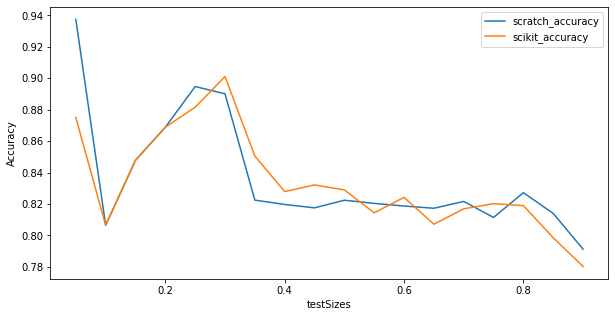

In [103]:
x = splitout
y = knna

fig, ax = plt.subplots(figsize=(10,5))
plt.xlabel('testSizes')
plt.ylabel('Accuracy')

line1, = ax.plot(x, y, label = 'scratch_accuracy')



y = scikita
line2, = ax.plot(x, y, label = 'scikit_accuracy')

ax.legend()
plt.show()

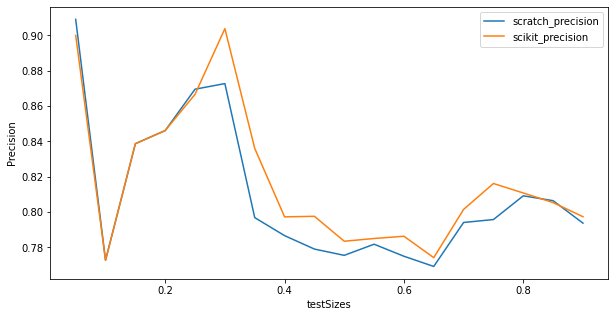

In [104]:
x = splitout
y = knnp

fig, ax = plt.subplots(figsize=(10,5))
plt.xlabel('testSizes')
plt.ylabel('Precision')

line1, = ax.plot(x, y, label = 'scratch_precision')



y = scikitp
line2, = ax.plot(x, y, label = 'scikit_precision')

ax.legend()
plt.show()

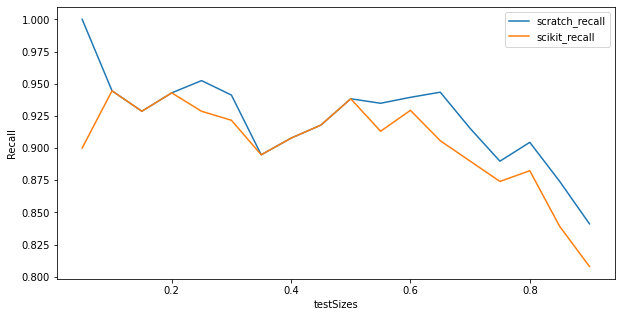

In [105]:
x = splitout
y = knnr

fig, ax = plt.subplots(figsize=(10,5))
plt.xlabel('testSizes')
plt.ylabel('Recall')

line1, = ax.plot(x, y, label = 'scratch_recall')



y = scikitr
line2, = ax.plot(x, y, label = 'scikit_recall')

ax.legend()
plt.show()

In [19]:
X= dataset.drop(['target'], axis=1)
Y= dataset['target']

knn1 = KNeighborsClassifier(n_neighbors=16, metric='euclidean')
sfs1 = SequentialFeatureSelector(knn1,scoring='accuracy',n_features_to_select=5)
X_train, X_test, Y_train, Y_test= train_test_split(X, Y, test_size=0.25, random_state=40)

sfs1.fit(X_train,Y_train)
features = sfs1.get_support()
print("Selected Features: ")
for j in range(len(features)):
    if (features[j] == True):
        print(str(j+1), end = " ")
featureset = sfs(2,16)

k = 16
scikita = []
scikitp = []
scikitr = []
knna = []
knnp = []
knnr = []
splitout = []


for z in range (1,19):
    split = float(0.05)*z
    X_train, X_test, Y_train, Y_test= train_test_split(X, Y, test_size=split, random_state=40)
    knn1 = KNeighborsClassifier(n_neighbors=k, metric='euclidean')
    knnmodel = knn1.fit(sfs1.transform(X_train), Y_train)
    knnpredict = knnmodel.predict(sfs1.transform(X_test))
    cmknn = confusion_matrix(Y_test, knnpredict)
    scikita.append(accuracy_score(Y_test, knnpredict))
    scikitp.append(precision_score(Y_test, knnpredict))
    scikitr.append(recall_score(Y_test, knnpredict))
    knnout = knn(2, X_train[featureset].to_numpy(), X_test[featureset].to_numpy(), Y_train, Y_test, 16)
    knna.append(accuracy_score(Y_test, knnout))
    knnp.append(precision_score(Y_test, knnout))
    knnr.append(recall_score(Y_test, knnout))
    splitout.append(split)

Selected Features: 
2 3 10 12 13 Final featureset: [2, 3, 7, 12, 13]


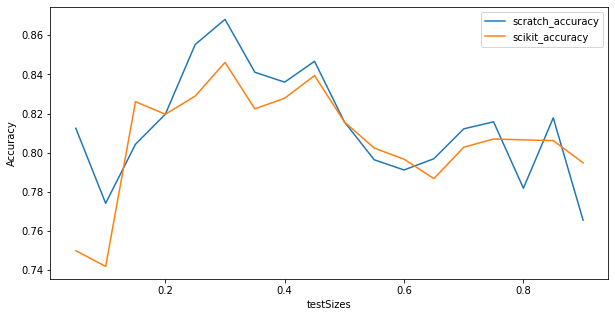

In [122]:
x = splitout
y = knna

fig, ax = plt.subplots(figsize=(10,5))
plt.xlabel('testSizes')
plt.ylabel('Accuracy')

line1, = ax.plot(x, y, label = 'scratch_accuracy')



y = scikita
line2, = ax.plot(x, y, label = 'scikit_accuracy')

ax.legend()
plt.show()

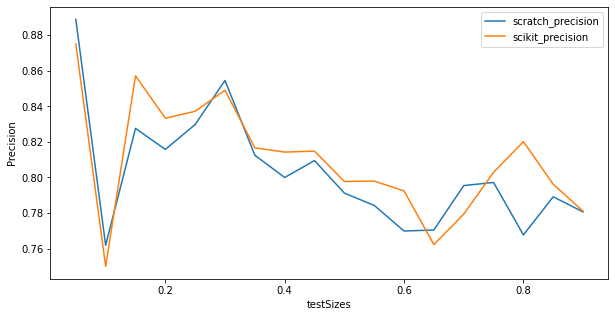

In [123]:
x = splitout
y = knnp

fig, ax = plt.subplots(figsize=(10,5))
plt.xlabel('testSizes')
plt.ylabel('Precision')

line1, = ax.plot(x, y, label = 'scratch_precision')



y = scikitp
line2, = ax.plot(x, y, label = 'scikit_precision')

ax.legend()
plt.show()

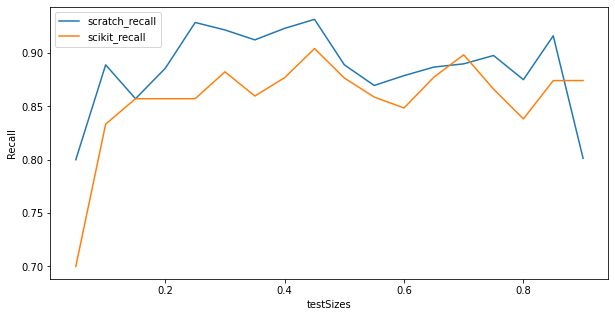

In [124]:
x = splitout
y = knnr

fig, ax = plt.subplots(figsize=(10,5))
plt.xlabel('testSizes')
plt.ylabel('Recall')

line1, = ax.plot(x, y, label = 'scratch_recall')



y = scikitr
line2, = ax.plot(x, y, label = 'scikit_recall')

ax.legend()
plt.show()

In [20]:
X= dataset.drop(['target'], axis=1)
Y= dataset['target']

knn1 = KNeighborsClassifier(n_neighbors=16, metric='euclidean')
pca = PCA(n_components = 5)
X_train, X_test, Y_train, Y_test= train_test_split(X, Y, test_size=0.25, random_state=40)

pca.fit(X_train,Y_train)

transform_vect = pca_scratch_2(X_train)



k = 16
scikita = []
scikitp = []
scikitr = []
knna = []
knnp = []
knnr = []
splitout = []


for z in range (1,19):
    split = float(0.05)*z
    X_train, X_test, Y_train, Y_test= train_test_split(X, Y, test_size=split, random_state=40)
    knn1 = KNeighborsClassifier(n_neighbors=k, metric='euclidean')
    knnmodel = knn1.fit(pca.transform(X_train), Y_train)
    knnpredict = knnmodel.predict(pca.transform(X_test))
    cmknn = confusion_matrix(Y_test, knnpredict)
    scikita.append(accuracy_score(Y_test, knnpredict))
    scikitp.append(precision_score(Y_test, knnpredict))
    scikitr.append(recall_score(Y_test, knnpredict))
    
    X_pca = np.dot(X_train,transform_vect.T)
    X_pca_test = np.dot(X_test,transform_vect.T)
    knnout = knn(2, X_pca, X_pca_test, Y_train, Y_test, 16)
    knna.append(accuracy_score(Y_test, knnout))
    knnp.append(precision_score(Y_test, knnout))
    knnr.append(recall_score(Y_test, knnout))
    splitout.append(split)

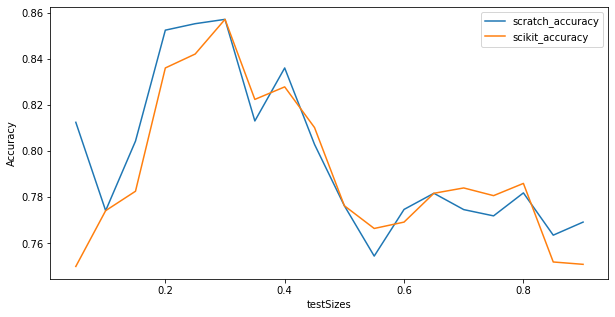

In [117]:
x = splitout
y = knna

fig, ax = plt.subplots(figsize=(10,5))
plt.xlabel('testSizes')
plt.ylabel('Accuracy')

line1, = ax.plot(x, y, label = 'scratch_accuracy')



y = scikita
line2, = ax.plot(x, y, label = 'scikit_accuracy')

ax.legend()
plt.show()

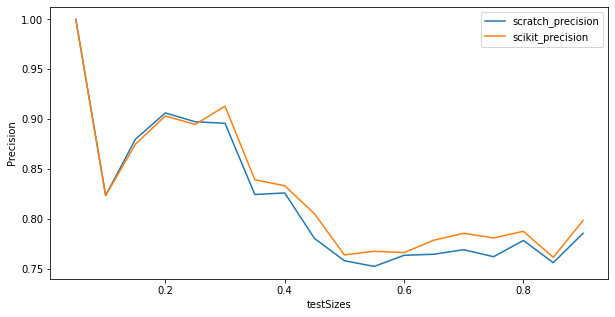

In [118]:
x = splitout
y = knnp

fig, ax = plt.subplots(figsize=(10,5))
plt.xlabel('testSizes')
plt.ylabel('Precision')

line1, = ax.plot(x, y, label = 'scratch_precision')



y = scikitp
line2, = ax.plot(x, y, label = 'scikit_precision')

ax.legend()
plt.show()

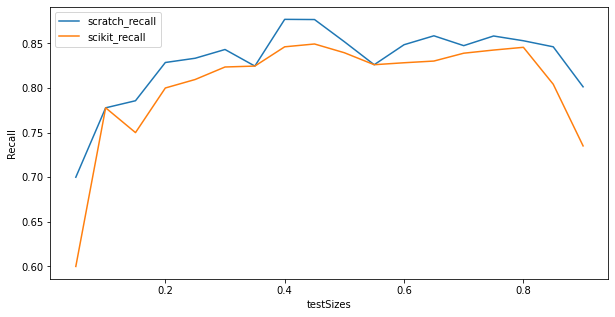

In [119]:
x = splitout
y = knnr

fig, ax = plt.subplots(figsize=(10,5))
plt.xlabel('testSizes')
plt.ylabel('Recall')

line1, = ax.plot(x, y, label = 'scratch_recall')



y = scikitr
line2, = ax.plot(x, y, label = 'scikit_recall')

ax.legend()
plt.show()

In [21]:
X= dataset.drop(['target'], axis=1)
Y= dataset['target']

knn1 = KNeighborsClassifier(n_neighbors=16, metric='euclidean')
lda = LinearDiscriminantAnalysis()
X_train, X_test, Y_train, Y_test= train_test_split(X, Y, test_size=0.25, random_state=40)

lda.fit(X_train,Y_train)

transform_vect = lda_scratch_2(X_train,Y_train,13)



k = 16
scikita = []
scikitp = []
scikitr = []
knna = []
knnp = []
knnr = []
splitout = []


for z in range (1,19):
    split = float(0.05)*z
    X_train, X_test, Y_train, Y_test= train_test_split(X, Y, test_size=split, random_state=40)
    knn1 = KNeighborsClassifier(n_neighbors=k, metric='euclidean')
    knnmodel = knn1.fit(pca.transform(X_train), Y_train)
    knnpredict = knnmodel.predict(pca.transform(X_test))
    cmknn = confusion_matrix(Y_test, knnpredict)
    scikita.append(accuracy_score(Y_test, knnpredict))
    scikitp.append(precision_score(Y_test, knnpredict))
    scikitr.append(recall_score(Y_test, knnpredict))
    
    X_pca = np.dot(X_train,transform_vect.T)
    X_pca_test = np.dot(X_test,transform_vect.T)
    knnout = knn(2, X_pca, X_pca_test, Y_train, Y_test, 16)
    knna.append(accuracy_score(Y_test, knnout))
    knnp.append(precision_score(Y_test, knnout))
    knnr.append(recall_score(Y_test, knnout))
    splitout.append(split)

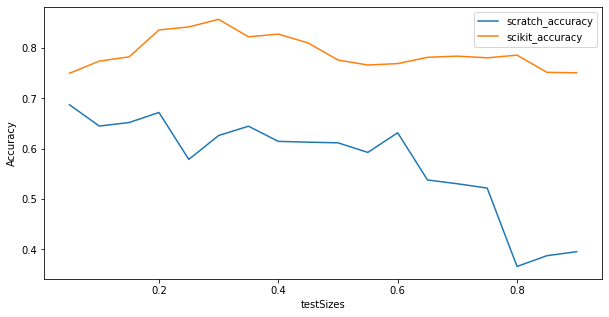

In [128]:
x = splitout
y = knna

fig, ax = plt.subplots(figsize=(10,5))
plt.xlabel('testSizes')
plt.ylabel('Accuracy')

line1, = ax.plot(x, y, label = 'scratch_accuracy')



y = scikita
line2, = ax.plot(x, y, label = 'scikit_accuracy')

ax.legend()
plt.show()

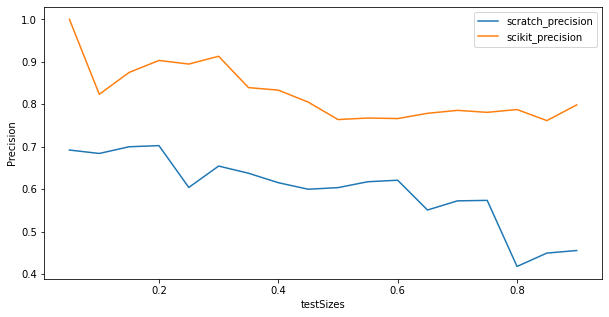

In [129]:
x = splitout
y = knnp

fig, ax = plt.subplots(figsize=(10,5))
plt.xlabel('testSizes')
plt.ylabel('Precision')

line1, = ax.plot(x, y, label = 'scratch_precision')



y = scikitp
line2, = ax.plot(x, y, label = 'scikit_precision')

ax.legend()
plt.show()

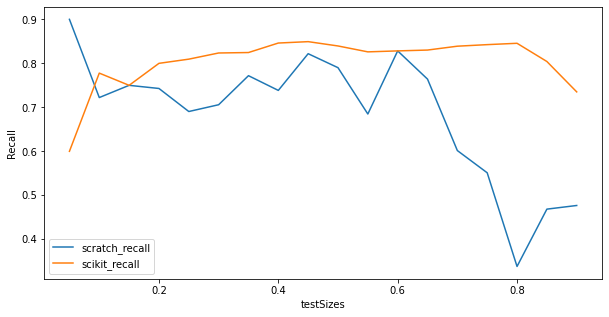

In [130]:
x = splitout
y = knnr

fig, ax = plt.subplots(figsize=(10,5))
plt.xlabel('testSizes')
plt.ylabel('Recall')

line1, = ax.plot(x, y, label = 'scratch_recall')



y = scikitr
line2, = ax.plot(x, y, label = 'scikit_recall')

ax.legend()
plt.show()

In [16]:
k = 17
knn1 = KNeighborsClassifier(n_neighbors=k, metric='manhattan')
pca = PCA(n_components = 5)
pca.fit(X_train,Y_train)
transform_vect = pca_scratch_2(X_train)


knnmodel = knn1.fit(pca.transform(X_train), Y_train)
knnpredict = knnmodel.predict(pca.transform(X_test))
cmknn = confusion_matrix(Y_test, knnpredict)
print("SciKit |", 'mahattan', "| K Neighbors = ", k,'\n', cmknn)
print("\nAccuracy=", accuracy_score(Y_test, knnpredict),"\n")

distfunc = 1 #P value for minkowski distance
X_pca = np.dot(X_train,transform_vect.T)
X_pca_test = np.dot(X_test,transform_vect.T)
Y_predictions = knn(distfunc, X_pca, X_pca_test, Y_train, Y_test, k)

cmknn = confusion_matrix(Y_test, Y_predictions)
print("Scratch |", 'mahattan', "| K Neighbors = ", k,'\n', cmknn)
print("\nAccuracy=", accuracy_score(Y_test, Y_predictions),"\n")
print("\nPrecision=", precision_score(Y_test, Y_predictions), "\n")
print("\nRecall= ", recall_score(Y_test, Y_predictions), "\n")

SciKit | mahattan | K Neighbors =  17 
 [[29  5]
 [ 7 35]]

Accuracy= 0.8421052631578947 

Scratch | mahattan | K Neighbors =  17 
 [[29  5]
 [ 7 35]]

Accuracy= 0.8421052631578947 


Precision= 0.875 


Recall=  0.8333333333333334 



11
0.881578947368421


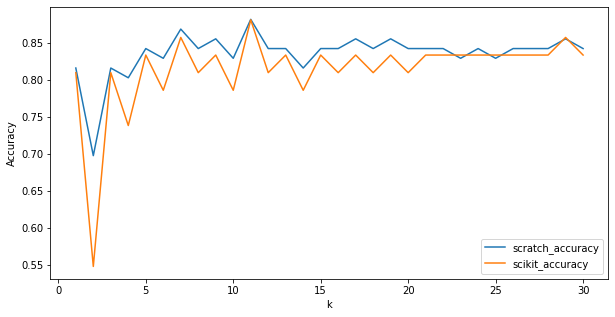

[[29  5]
 [ 6 36]]
0.8421052631578947
0.875
0.8333333333333334
18
0.8552631578947368



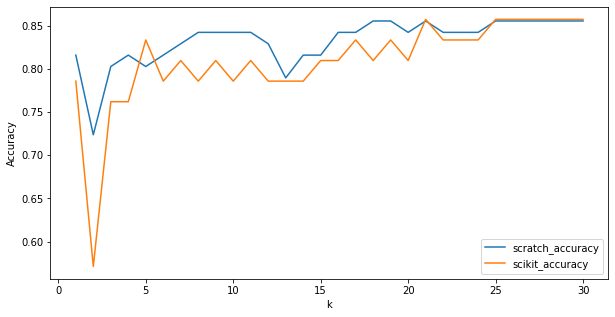

In [34]:
scikita = []
scikitp = []
scikitr = []
knna = []
knnp = []
knnr = []
splitout = []


for k in range (1,31):
    X_train, X_test, Y_train, Y_test= train_test_split(X, Y, test_size=0.25, random_state=40)
    knn1 = KNeighborsClassifier(n_neighbors=k, metric='euclidean')
    knnmodel = knn1.fit(pca.transform(X_train), Y_train)
    knnpredict = knnmodel.predict(pca.transform(X_test))
    cmknn = confusion_matrix(Y_test, knnpredict)
    scikita.append(accuracy_score(Y_test, knnpredict))
    scikitp.append(precision_score(Y_test, knnpredict))
    scikitr.append(recall_score(Y_test, knnpredict))
    
    X_pca = np.dot(X_train,transform_vect.T)
    X_pca_test = np.dot(X_test,transform_vect.T)
    knnout = knn(2, X_pca, X_pca_test, Y_train, Y_test, k)
    knna.append(accuracy_score(Y_test, knnout))
    knnp.append(precision_score(Y_test, knnout))
    knnr.append(recall_score(Y_test, knnout))
    
print(np.argmax(scikita) + 1)
print(scikita[np.argmax(scikita)])
x = range(1,31)
y = scikita

fig, ax = plt.subplots(figsize=(10,5))
plt.xlabel('k')
plt.ylabel('Accuracy')

line1, = ax.plot(x, y, label = 'scratch_accuracy')



y = scikitr
line2, = ax.plot(x, y, label = 'scikit_accuracy')

ax.legend()
plt.show()

scikita = []
scikitp = []
scikitr = []
knna = []
knnp = []
knnr = []
splitout = []
for k in range (1,31):
    knn1 = KNeighborsClassifier(n_neighbors=k, metric='manhattan')
    knnmodel = knn1.fit(pca.transform(X_train), Y_train)
    knnpredict = knnmodel.predict(pca.transform(X_test))
    scikita.append(accuracy_score(Y_test, knnpredict))
    scikitp.append(precision_score(Y_test, knnpredict))
    scikitr.append(recall_score(Y_test, knnpredict))
    
    X_pca = np.dot(X_train,transform_vect.T)
    X_pca_test = np.dot(X_test,transform_vect.T)
    knnout = knn(1, X_pca, X_pca_test, Y_train, Y_test, k)
    knna.append(accuracy_score(Y_test, knnout))
    knnp.append(precision_score(Y_test, knnout))
    knnr.append(recall_score(Y_test, knnout))
    

print(np.argmax(scikita) + 1)
print(scikita[np.argmax(scikita)])
print()
x = range(1,31)
y = scikita

fig, ax2 = plt.subplots(figsize=(10,5))
plt.xlabel('k')
plt.ylabel('Accuracy')

line3, = ax2.plot(x, y, label = 'scratch_accuracy')



y = scikitr
line4, = ax2.plot(x, y, label = 'scikit_accuracy')

ax2.legend()
plt.show()

[[29  5]
 [ 6 36]]
0.8421052631578947
0.875
0.8333333333333334


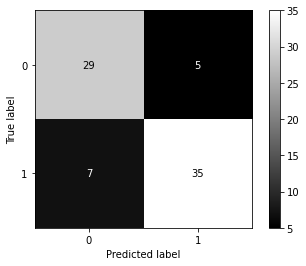

In [51]:
knnout = knn(1, X_pca, X_pca_test, Y_train, Y_test, 17)
cmknn = confusion_matrix(Y_test, knnpredict)
print(cmknn)
print(accuracy_score(Y_test, knnout))
print(precision_score(Y_test, knnout))
print(recall_score(Y_test, knnout))
disp = ConfusionMatrixDisplay.from_predictions(Y_test, knnout, cmap='gray')
plt.show()
